In [ ]:
# Importing TensorFlow and checking GPU availability
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Mounting Google Drive to access and save files persistently
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

TensorFlow version: 2.19.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mounted at /content/drive


In [ ]:
# Installing Kaggle CLI tool to download datasets directly from kaggle
!pip install kaggle

# Uploading my Kaggle API key (kaggle.json)
from google.colab import files
files.upload()  # Selecting my kaggle.json file here

# Moving kaggle.json to the correct folder and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:

# Downloading the breast cancer histopathology dataset
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

# Unzipping into dataset folder
!unzip breast-histopathology-images.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: /content/dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: /content/dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: /content/dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: /content/dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: /content/dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: /content/dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: /content/dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: /content/dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: /content/dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflati

In [ ]:

# Quickly checking how dataset is structured
import os

data_path = "/content/dataset"
for root, dirs, files in os.walk(data_path):
    print(root, "contains", len(files), "files")
    if len(dirs) > 0:
        print("Subfolders:", dirs[:5])
    break  # Just previewing the top level

/content/dataset contains 0 files
Subfolders: ['14305', '12886', '13688', '13461', '9254']


In [ ]:
import os, shutil, random
from pathlib import Path

# Defining dataset paths
original_dataset = Path("/content/dataset")
base_dir = Path("/content/dataset_clean")
train_dir = base_dir / "train"
val_dir = base_dir / "val"

# Creating folders for training and validation and both labels (0 and 1)
for split in ["train", "val"]:
    for label in ["0", "1"]:
        os.makedirs(base_dir / split / label, exist_ok=True)

# Defining parameters
val_split = 0.2  # 20% for validation
max_images_per_class = 6000  # limiting to avoid Colab crashes since im using free tier

# Randomly splitting images into training and validation sets
for label in ["0", "1"]:
    all_images = []
    for folder in original_dataset.iterdir():
        label_folder = folder / label
        if label_folder.exists():
            all_images.extend(list(label_folder.glob("*.png")))

    random.shuffle(all_images)
    all_images = all_images[:max_images_per_class]

    split_idx = int(len(all_images) * (1 - val_split))
    train_files = all_images[:split_idx]
    val_files = all_images[split_idx:]

    for f in train_files:
        shutil.copy(f, train_dir / label / f.name)
    for f in val_files:
        shutil.copy(f, val_dir / label / f.name)

print("✅ Dataset organized successfully!")


✅ Dataset organized successfully!


In [ ]:

# Checking number of images per folder
base_dir = "/content/dataset_clean"

for split in ["train", "val"]:
    for label in ["0", "1"]:
        folder = os.path.join(base_dir, split, label)
        print(f"{split}/{label}: {len(os.listdir(folder))} images")

train/0: 4800 images
train/1: 4800 images
val/0: 1200 images
val/1: 1200 images


In [ ]:
import tensorflow as tf

# Image size for ResNet
img_size = (224, 224)
batch_size = 32

# Loading and preprocessing training and validation data
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset_clean/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset_clean/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

# Optimizing data loading performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 9600 files belonging to 2 classes.
Found 2400 files belonging to 2 classes.


Found 9600 files belonging to 2 classes.
Classes: ['0', '1']


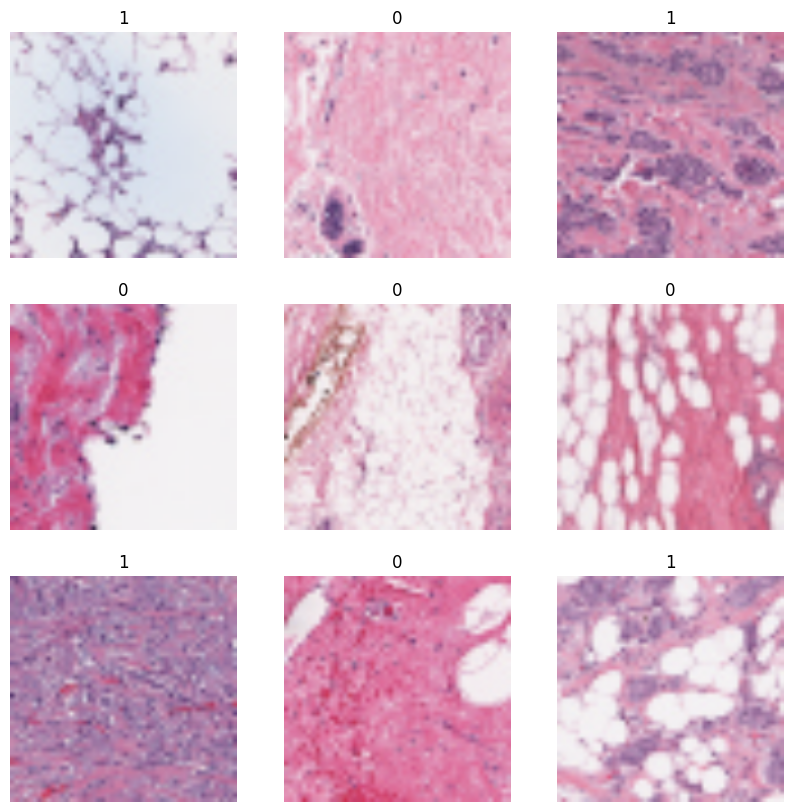

In [ ]:
import matplotlib.pyplot as plt

# Reloading a raw dataset for visualization
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset_clean/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

class_names = raw_train_ds.class_names
print("Classes:", class_names)

# Displaying 9 random images with labels
plt.figure(figsize=(10, 10))
for images, labels in raw_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Loading ResNet50 without the top layer (transfer learning)
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freezing base layers initially
base_model.trainable = False

# Adding custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation="softmax")  # two classes: 0 and 1
])

# Compiling model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Saving model to Google Drive
checkpoint_path = "/content/drive/MyDrive/best_model.h5"

# Defining callbacks for early stopping and best model saving
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Training model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

print(f"✅ Model training complete. Saved best model to: {checkpoint_path}")

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7642 - loss: 0.5351
Epoch 1: val_accuracy improved from -inf to 0.84333, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 73s 143ms/step - accuracy: 0.7643 - loss: 0.5349 - val_accuracy: 0.8433 - val_loss: 0.3712
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8238 - loss: 0.4090
Epoch 2: val_accuracy did not improve from 0.84333
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.8238 - loss: 0.4090 - val_accuracy: 0.8392 - val_loss: 0.3695
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8413 - loss: 0.3710
Epoch 3: val_accuracy improved from 0.84333 to 0.84708, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - accuracy: 0.8413 - loss: 0.3710 - val_accuracy: 0.8471 - val_loss: 0.3564
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8390 - loss: 0.3696
Epoch 4: val_accuracy improved from 0.84708 to 0.85333, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.8390 - loss: 0.3696 - val_accuracy: 0.8533 - val_loss: 0.3538
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8469 - loss: 0.3550
Epoch 5: val_accuracy did not improve from 0.85333
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - accuracy: 0.8469 - loss: 0.3550 - val_accuracy: 0.8467 - val_loss: 0.3590
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8481 - loss: 0.3562
Epoch 6: val_accuracy improved from 0.85333 to 0.85417, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - accuracy: 0.8481 - loss: 0.3561 - val_accuracy: 0.8542 - val_loss: 0.3523
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8530 - loss: 0.3453
Epoch 7: val_accuracy did not improve from 0.85417
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - accuracy: 0.8530 - loss: 0.3453 - val_accuracy: 0.8483 - val_loss: 0.3535
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8637 - loss: 0.3307
Epoch 8: val_accuracy did not improve from 0.85417
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - accuracy: 0.8637 - loss: 0.3307 - val_accuracy: 0.8454 - val_loss: 0.3608
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8564 - loss: 0.3231
Epoch 9: val_accuracy did not improve from 0.85417
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - accuracy: 0.8564 - loss: 0.3231 - val_accuracy: 0.8508 - val_loss: 0.3521
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8584 - loss: 0.3220
Epoch 10: val_accurac